# *Capstone project - Analysing 911 calls*
For the capstone project, I am analysing data of calls received by the 911 hotline in the City of Baltimore, with the goal of modeling and predicting emergencies based on caller's information. This analysis is beneficial in the following ways.
- Cities can better plan for future emergencies, basing locations for new fire stations, police stations and hospitals on areas with high 911 traffic.
- Emergency units can manage manpower more efficiently during different hours of the day or days of the week based on the likelihood of particular emergencies during those periods.
- Residents of an area can become better aware of the emergencies and therefore be better prepared to avoid them (mainly criminal emergencies).

As the data source I am using the city of Baltimore's '911 Police Calls for Service' database which contains over 6 million entries of 911 calls with data on date, time, location and text descriptions of emergencies in the city for the past 6 years. 

Mathematically, this is a multi-dimensional regression problem, where we need to learn to predict the count of particular emergencies (fire, police, medical) based on the caller's geographic location and temporal information. So, we'll be following typical machine learning protocol.
We'll be testing multiple regression algorithms, Linear models like Ridge and Lasso, Non-linear/Non-parametric models like KNearestNeighbors and emsemble models such as RandomForestRegressor and through Cross Validation, find the best fit for our data, measured by standard performance metrics like $R^2$. 

In this jupyter notebook, I perform some exploratory data analysis to figure out whether the 911 call data does indeed show underlying patterns worth spending our time on. Then, we'll go ahead and train our predictive model, which will be used by our webapp.

## Exploratory data analysis

First, we load the dataset into python and take a look at the meta data on the input.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
data911 = pd.read_csv('911_Police_Calls_for_Service.csv')#, nrows = 700000)

In [4]:
data911['Priority'].unique()

array(['Non-Emergency', 'Low', 'Medium', 'High', 'Emergency',
       'Out of Service', nan], dtype=object)

In [5]:
def todatetime(X, col, form):
    X[col] = pd.to_datetime(X[col], format = form)
    return X

def trimedges(X, col):
    first_date = min(X[col].dt.date)
    last_date = max(X[col].dt.date)
    X = X[X[col].dt.date != first_date] 
    X = X[X[col].dt.date != last_date]
    return X

We convert date and time to their proper format and we go ahead and trim the ends our time series data, since they are incomplete. 

In [6]:
data911 = todatetime(data911, 'CallDateTime', '%m/%d/%Y %I:%M:%S %p')
data911 = trimedges(data911, 'CallDateTime')
data911 = data911.dropna(subset=['Neighborhood'])
data911 = data911[data911.Priority != 'Out of Service']

The dataset has 6,388,610 entries with 17 features. Although a lot of these features like the 'RecordID' shouldn't be of much use. There are also 'PoliceDistrict', 'District' and 'Neighborhood' which are essentially the same information.

Next, we group our data by PoliceDistrict and check for fluctuations in the number of 911 calls from the these districts over 6 years. The goal is to get an idea as to whether geographic location has any bearing on the number of emergencies there.

Interestingly, the data shows very little temporal variation. Instead, what we see is a steady but different rate of 911 calls coming in from different districts. The simplest explanation could have been the population/size of these districts, but that did not turn out to be the case. The 'Northeastern' district, right next to the 'Northern' district is also roughly the same size. Yet, there is a consistent 40% higher rate of 911 calls coming in from that district. Curious, indeed!

Note - I ignore the 2013 data being much less on account of it being the first year in the dataset and the data might not have been collected from the start of the year.

In [7]:
d = data911.groupby(['PoliceDistrict', pd.Grouper(key='CallDateTime', freq='Y')])['RecordID'].count().unstack()

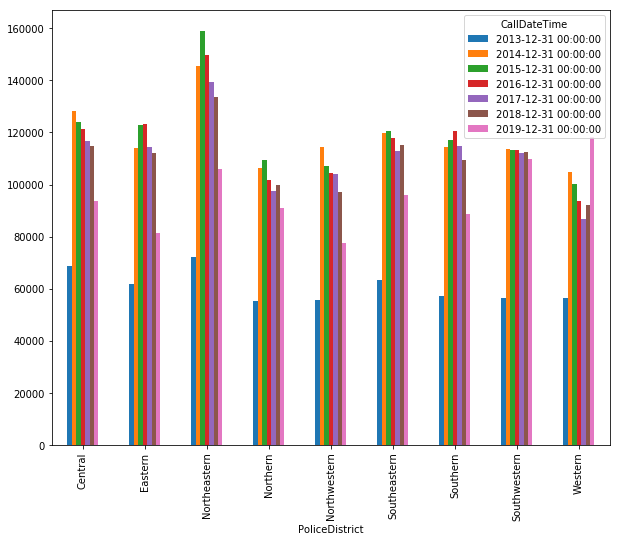

In [8]:
d.plot.bar(figsize = (10,8), stacked = False)

Just to make this difference more apparent, I have a boxplot of the total number of 911 calls for the 9 districts given below, which better depicts the variation.

Text(0,0.5,'# of 911 calls')

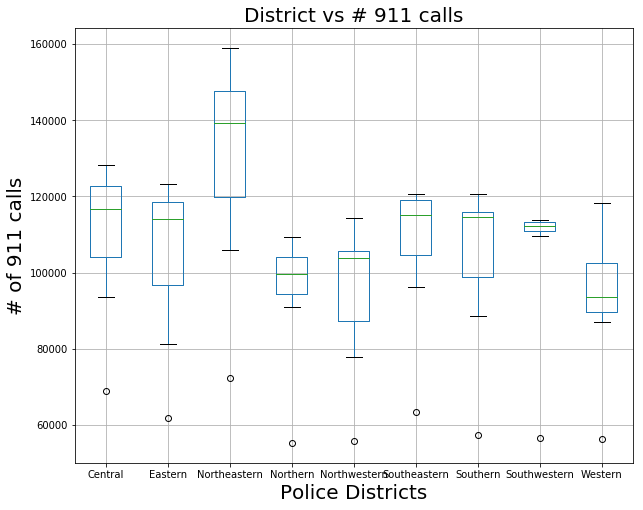

In [9]:
d = data911.groupby([pd.Grouper(key='CallDateTime', freq='Y'), 'PoliceDistrict']).count()['RecordID'].unstack()
fig = d.boxplot(figsize = (10,8))
fig.set_title('District vs # 911 calls', size = 20)
fig.set_xlabel('Police Districts', size = 20)
fig.set_ylabel('# of 911 calls', size = 20)

Now, we try to go deeper into the contents of these calls. I have a word cloud of the 'Call Descriptions' displayed, which gives us an idea about the emergencies that occur most frequently in the city.

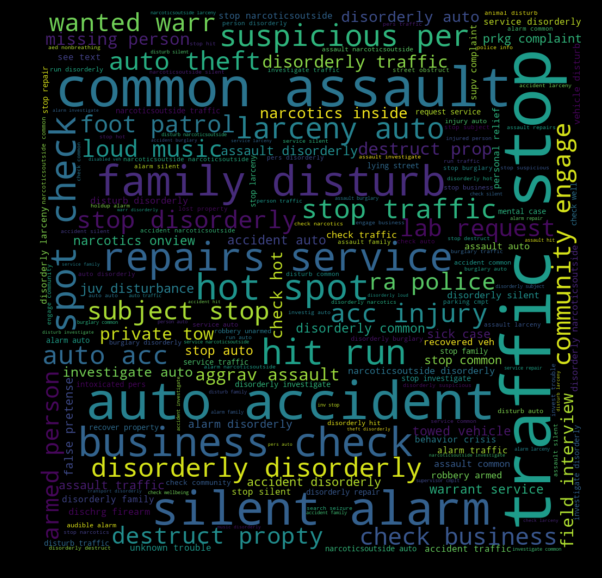

In [10]:
from wordcloud import WordCloud, STOPWORDS

data911['Description'] = data911['Description'].str.lower()
data911['Description'] = data911['Description'].replace(to_replace = '911/no  voice' , value = '911/no voice')
data911['Description'] = data911['Description'].replace(to_replace = '911/no voice' , value = 'no voice')
d = data911[data911.Description != 'no voice']
wordcloud = WordCloud(width = 1000, height = 1000, stopwords = STOPWORDS).generate(str(d.Description.to_string()))


plt.figure(figsize = (10, 10), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')

In [11]:
print(data911.groupby('Description')['Description'].count().sort_values(ascending = False).head(10))

Description
no voice            962359
disorderly          571055
traffic stop        457856
common assault      279340
auto accident       255042
narcoticsoutside    205864
silent alarm        203362
other               197284
family disturb      162105
business check      154087
Name: Description, dtype: int64


The most common descriptions as it turns out, are 'disorderly' (conduct), 'traffic stop' and 'common assault'. Lets take a closer look at one of these.

We look at the calls about disorderly conduct only, grouping the data by district and look at a boxplot of the number of calls received in each district from 2013 to 2019.

Text(0,0.5,'# of 911 calls')

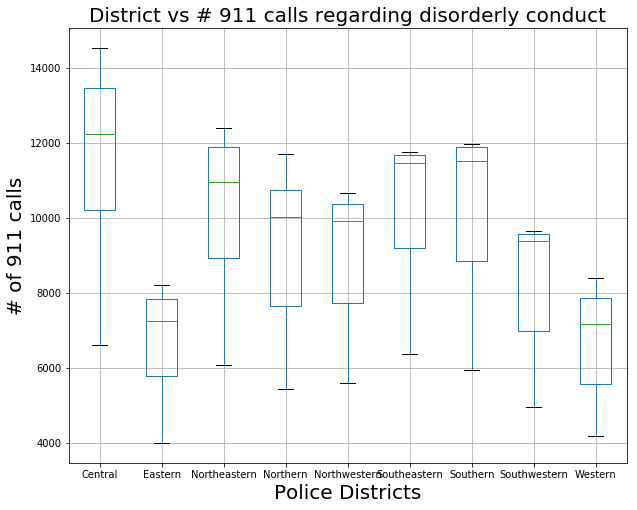

In [12]:
d = data911[data911['Description'].str.find('disorderly') != -1]
d = d.groupby([pd.Grouper(key='CallDateTime', freq='Y'), 'PoliceDistrict']).count()['RecordID'].unstack()

fig = d.boxplot(figsize = (10,8))
fig.set_title('District vs # 911 calls regarding disorderly conduct', size = 20)
fig.set_xlabel('Police Districts', size = 20)
fig.set_ylabel('# of 911 calls', size = 20)

The results are considerable different than when we looked all the data. While the 'Northern' district received the most 911 calls overall, it is infact the 'Central' district that has faced the issue of disorderly conduct more.

Clearly, the frequency of 911 calls are related to the locations the calls are made from and the reason for making them. 

# *ML Model*

We now implement our machine learning pipeline to learn call counts from the data, based on the date, location and priority of the call.

In [13]:
from sklearn import base
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [14]:
import dill

import ipywidgets as widgets
from ipywidgets import fixed, interact
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [15]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names 
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.col_names]

We group the data by week, PoliceDistrict and priority of call, and aggregate on the number of emergencies. 

In [16]:
data = data911.groupby([pd.Grouper(key='CallDateTime', freq='W'), 'PoliceDistrict', 'Priority']) \
                    [['RecordID']].count()
data = data.reset_index()
data = data.rename(columns={'RecordID':'Count'})
data['Julian'] = pd.DatetimeIndex(data['CallDateTime']).to_julian_date()
data = data.sample(frac=1,random_state=42).reset_index(drop=True)
data.head(5)

data.to_pickle("./weekly_data.pkl")

Here we perform feature engineering for our ML pipeline. We one hot encode out categorical variables, i.e. PoliceDistrict and Priority. We also add polynomial features to our model corresponding to the Julian date.

In [17]:
cat_cols = ['PoliceDistrict', 'Priority']
poly_cols = ['Julian']
y = data['Count']

In [18]:
cat_features = Pipeline([
                ('cst', ColumnSelectTransformer(cat_cols)),
                ('ohe', OneHotEncoder())])


poly_features = Pipeline([
                ('cst', ColumnSelectTransformer(poly_cols)),
                ('poly', PolynomialFeatures())])

features = FeatureUnion([
            ('cat_features', cat_features),
            ('poly_features', poly_features)])

est = Pipeline([
        ('features', features),
        ('scale', StandardScaler(with_mean=False)),
        ('estimator', Ridge())])

We perform cross validation over Linear models - Ridge and Lasso, a Non-linear/Non-parametric model - KNearestNeighbors and an emsemble model - RandomForestRegressor and choose the best fit for the data.

In [19]:
parametersCV = [
                {'features__poly_features__poly__degree' : [1, 2],
                 'estimator' : [Ridge()],
                 'estimator__alpha' : np.linspace(0, 500, 10)},
                
                {'features__poly_features__poly__degree' : [1, 2],
                 'estimator' : [Lasso()],
                 'estimator__alpha' : np.linspace(0, 200, 10)},
    
                {'features__poly_features__poly__degree' : [1, 2],
                 'estimator' : [KNeighborsRegressor()],
                 'estimator__n_neighbors' : list(map(int, np.linspace(1, 10, 10)))},

                {'features__poly_features__poly__degree' : [1, 2],
                 'estimator' : [RandomForestRegressor(n_estimators = 100)],
                 'estimator__max_depth' : list(map(int, np.linspace(1, 10, 5))),
                 'estimator__min_samples_split' : list(map(int, np.linspace(5, 20, 3)))}
               ]

model = GridSearchCV(est, parametersCV, cv = 3, n_jobs = 1, verbose = 3, return_train_score = True)

Save the model since training is computationally expensive.

In [27]:
try:
    model = dill.load(open('model_julian_weekly.dill', 'rb'))
except (OSError, IOError) as e:
    model.fit(data, y)
    dill.dump(model, open('model_julian_weekly.dill', 'wb'))

The emsemble model performs the best for our problem, with a CV score of 0.95.

In [28]:
print(model.best_params_)
print('CV score :', model.best_score_)

{'estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False), 'estimator__max_depth': 10, 'estimator__min_samples_split': 12, 'features__poly_features__poly__degree': 2}
CV score : 0.9577352422544175


In [29]:
district = widgets.Dropdown(
                    options=['Central', 'Eastern', 'Northeastern', 'Northern', 'Northwestern', 
                             'Southeastern', 'Southern', 'Southwestern', 'Western'],
                    value='Northeastern',
                    description='District:',
                    disabled=False,
                    )

priority = widgets.Dropdown(
            options=['Emergency', 'High', 'Medium', 'Low', 'Non-Emergency'],
            value='Medium',
            description='Priority:',
            disabled=False,
            )

In [30]:
output_notebook()

Loading BokehJS ...

In [31]:
def plot_prediction(data, model, district, priority):
    d = data[data.Priority == priority]
    d = d[d.PoliceDistrict == district]
    d['Count_Predict'] = model.predict(d)
    d = d.sort_values(by=['CallDateTime'])
    
    fig = figure(width=500, height=500, x_axis_type='datetime')
    fig.xaxis.axis_label = 'Date'
    fig.yaxis.axis_label = 'Emergency count'
    
    fig.circle(x='CallDateTime', y='Count', source=d, color='grey')  
    fig.line(x='CallDateTime', y='Count_Predict', source=d, line_width=3, color='red')  
    show(fig)

In [32]:
interact(plot_prediction, data=fixed(data), model=fixed(model), district=district, priority=priority)

interactive(children=(Dropdown(description='District:', index=2, options=('Central', 'Eastern', 'Northeastern', 'Northern', 'Northwestern', 'Southeastern', 'Southern', 'Southwestern', 'Western'), value='Northeastern'), Dropdown(description='Priority:', index=2, options=('Emergency', 'High', 'Medium', 'Low', 'Non-Emergency'), value='Medium'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_prediction(data, model, district, priority)>

As seen from the plots, our RandomForestRegressor model performs reasonably well.